In [2]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [25]:
import duckdb
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

In [4]:
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

Tip: You may define configurations in /Users/saadiqmohiuddin/Documents/gtfs-realtime-etl/notebooks/pyproject.toml or /Users/saadiqmohiuddin/.jupysql/config.

Did not find user configurations in /Users/saadiqmohiuddin/Documents/gtfs-realtime-etl/notebooks/pyproject.toml.

In [5]:
%%sql
INSTALL httpfs;
LOAD httpfs;
INSTALL spatial;
LOAD spatial;

,Success


In [6]:
%sql SET GLOBAL timezone='America/Toronto';

,Success


In [7]:
#Download and unzip merged ttc GTFS data: https://open.toronto.ca/dataset/merged-gtfs-ttc-routes-and-schedules/

In [28]:
%%sql
CREATE TABLE IF NOT EXISTS trips AS
    SELECT * FROM read_csv('data/ttc/trips.txt');

CREATE TABLE IF NOT EXISTS stops AS
SELECT
    *,
    ST_Point(stop_lon, stop_lat) AS stop_loc
FROM read_csv('data/ttc/stops.txt');

CREATE TABLE IF NOT EXISTS routes AS
    SELECT * FROM read_csv('data/ttc/routes.txt');

CREATE TABLE IF NOT EXISTS shapes AS
    SELECT * FROM read_csv('data/ttc/shapes.txt');

CREATE TABLE IF NOT EXISTS stop_times AS
    SELECT * FROM read_csv('data/ttc/stop_times.txt');

,Count


In [ ]:
#Create view of vehicle positions

In [19]:
%%sql 
CREATE VIEW IF NOT EXISTS locations AS
SELECT * FROM read_parquet('s3://gtfs-rt-etl-data/ttc/positions/year=*/month=*/day=*/*.parquet', hive_partitioning = true);
FROM (DESCRIBE locations);


,column_name,column_type,null,key,default,extra
0,trip_id,VARCHAR,YES,None,None,None
1,route_id,VARCHAR,YES,None,None,None
2,direction_id,VARCHAR,YES,None,None,None
3,vehicle_id,VARCHAR,YES,None,None,None
4,bearing,DOUBLE,YES,None,None,None
5,speed,DOUBLE,YES,None,None,None
6,timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None
7,geohash,VARCHAR,YES,None,None,None
8,geometry,GEOMETRY,YES,None,None,None
9,bbox,"STRUCT(xmin DOUBLE, ymin DOUBLE, xmax DOUBLE, ...",YES,None,None,None


In [20]:
%sql select count(*) from locations;

,count_star()
0,1892124


In [21]:
%%sql stops << SELECT 
    stop_id,
    COUNT(diff) AS count,
    AVG(diff) AS avg_diff,
    STDDEV(diff) AS stddev_diff,
    ST_X(stop_loc) AS long,
    ST_Y(stop_loc) AS lat
FROM (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY trip_id, stop_id, arrival_time, stop_sequence
            ORDER BY arrival_time ASC, ABS(diff) ASC
        ) AS rn
    FROM (
        SELECT 
            X.trip_id,
            T.route_short_name,
            S.stop_sequence,
            S.arrival_time,
            DATEDIFF(
                'seconds', 
                strftime(Y.timestamp, '%H:%M:%S')::TIME,
                S.arrival_time::TIME
            ) AS diff,
            S.stop_id,
            V.stop_loc
        FROM routes AS T
        JOIN trips AS X ON T.route_id = X.route_id
        JOIN stop_times AS S ON X.trip_id = S.trip_id
        JOIN stops AS V ON S.stop_id = V.stop_id
        JOIN locations AS Y
            ON X.trip_id = Y.trip_id
           AND ST_DWithin(Y.geometry, V.stop_loc, 0.0002)
        WHERE NOT regexp_matches(S.arrival_time, '^(2[4-9]|3[0-5]):', 'c')
    ) AS matched
    WHERE diff BETWEEN -600 AND 600 
) AS ranked
WHERE rn = 1
GROUP BY stop_id, stop_loc;

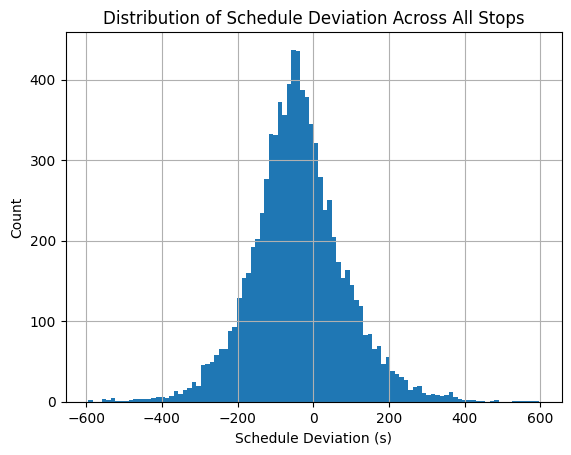

In [27]:
stops["avg_diff"].hist(bins=100)
plt.title("Distribution of Average Schedule Deviation Across All Stops")
plt.xlabel("Schedule Deviation (s)")
plt.ylabel("Count")
plt.show()